# Bonus 3: Implementation of InfoGAN

## Setup

/home/mcreng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


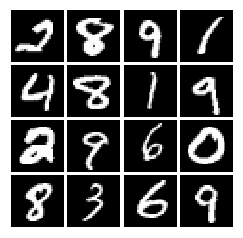

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

def leaky_relu(x, alpha=0.2):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha*x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], -1, 1)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## Solvers

In [2]:
def get_solvers(learning_rate=2e-4, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate*10, beta1=beta1)
    Q_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver, Q_solver

## run_a_gan
With the categorical variables generation

In [3]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              Q_train_step, Q_loss, Q_extra_step, \
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        cat_ = get_one_hot(np.random.randint(low=0, high=10, size=(batch_size)), 10)
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample, feed_dict={cat: cat_})
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, cat: cat_})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={cat: cat_})
        _, Q_loss_curr = sess.run([Q_train_step, Q_loss], feed_dict={cat: cat_})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G: {:.4}, Q: {:.4}'.format(it,D_loss_curr,G_loss_curr,Q_loss_curr))
    print('Final images')
    samples = sess.run(G_sample, feed_dict={cat: cat_})

    fig = show_images(samples[:16])
    plt.show()

# GAN setups
Original DCGAN with Q-Network

In [4]:
def discriminator(x, cat):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, (-1, 28, 28, 1))
        conv1 = tf.layers.conv2d(x, 32, (5,5), 1, activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(conv1, (2,2), 2)
        conv2 = tf.layers.conv2d(pool1, 64, (5,5), 1, activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(conv2, (2,2), 2)
        flat = tf.layers.flatten(pool2)
        fc = tf.layers.dense(flat, 4*4*64, activation=leaky_relu)
        
        logits = tf.layers.dense(fc, 1)
    
        qfc = tf.layers.dense(fc, 128, activation=leaky_relu)
        q_cat = tf.layers.dense(qfc, cat, activation=tf.nn.softmax)

        return logits, q_cat
    
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        im = tf.reshape(bn2, (-1, 7, 7, 128))
        convt1 = tf.layers.conv2d_transpose(im, 64, (4,4), 2, 'same', activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(convt1, training=True)
        convt2 = tf.layers.conv2d_transpose(bn3, 1, (4,4), 2, 'same', activation=tf.nn.tanh)
        img = tf.reshape(convt2, (-1, 784))
        return img


## GAN loss
With Q loss:
- Categorical vars: Negative Log Likelihood
- Continous vars: MLE

In [5]:
def gan_loss(logits_real, logits_fake, correct_cat, logits_cat):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits=logits_fake)
    G_loss = tf.reduce_mean(G_loss)

    D_loss1 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits=logits_real)
    D_loss2 = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits=logits_fake)
    D_loss = tf.reduce_mean(D_loss1) + tf.reduce_mean(D_loss2)
    
    Q_loss = -tf.reduce_mean(tf.reduce_sum(correct_cat*tf.log(logits_cat), axis=1))
    
    return D_loss, G_loss, Q_loss

## GAN setup

In [6]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

number_of_categories = 10

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# cat = tf.one_hot(tf.random_uniform((batch_size,), 0, number_of_categories, dtype=tf.int32), depth=number_of_categories)
cat = tf.placeholder(tf.float32, [None, number_of_categories])
generator_input = tf.concat(axis=1, values=[z, cat])
# generated images
G_sample = generator(generator_input)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real, _ = discriminator(preprocess_img(x), number_of_categories)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake, logits_cat = discriminator(G_sample, number_of_categories)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 
Q_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

D_solver, G_solver, Q_solver = get_solvers()
D_loss, G_loss, Q_loss = gan_loss(logits_real, logits_fake, cat, logits_cat)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
Q_train_step = Q_solver.minimize(Q_loss, var_list=Q_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')
Q_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

## Training

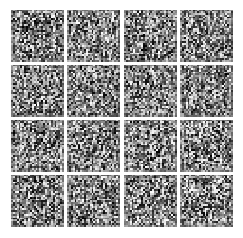


Iter: 0, D: 1.369, G: 0.8296, Q: 2.313
Iter: 50, D: 1.308, G: 0.5999, Q: 2.288
Iter: 100, D: 1.353, G: 0.9814, Q: 2.244
Iter: 150, D: 1.337, G: 0.6797, Q: 2.077
Iter: 200, D: 1.422, G: 0.9173, Q: 2.081


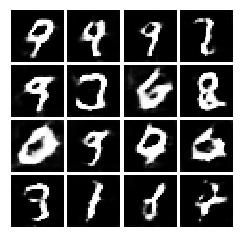


Iter: 250, D: 1.202, G: 0.961, Q: 1.776
Iter: 300, D: 1.435, G: 0.7411, Q: 1.818
Iter: 350, D: 1.368, G: 0.6385, Q: 1.541
Iter: 400, D: 1.6, G: 0.6274, Q: 1.384
Iter: 450, D: 1.363, G: 0.6577, Q: 1.047


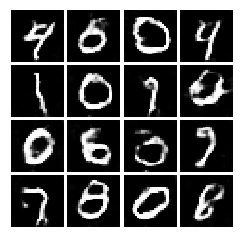


Iter: 500, D: 1.384, G: 0.6916, Q: 0.8919
Iter: 550, D: 1.409, G: 0.8056, Q: 0.6474
Iter: 600, D: 1.361, G: 0.7185, Q: 0.6346
Iter: 650, D: 1.39, G: 0.728, Q: 0.614
Iter: 700, D: 1.408, G: 0.818, Q: 0.5111


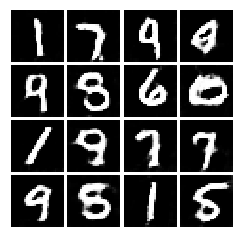


Iter: 750, D: 1.368, G: 0.8058, Q: 0.6333
Iter: 800, D: 1.36, G: 0.7883, Q: 0.4365
Iter: 850, D: 1.412, G: 0.725, Q: 0.4516
Iter: 900, D: 1.421, G: 0.7227, Q: 0.5026
Iter: 950, D: 1.458, G: 0.6861, Q: 0.5044


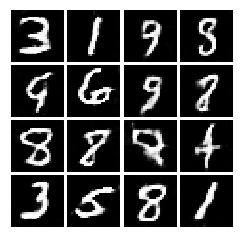


Iter: 1000, D: 1.429, G: 0.7463, Q: 0.4615
Iter: 1050, D: 1.403, G: 0.7061, Q: 0.3106
Iter: 1100, D: 1.401, G: 0.7335, Q: 0.3726
Iter: 1150, D: 1.41, G: 0.7136, Q: 0.4713
Iter: 1200, D: 1.394, G: 0.727, Q: 0.3108


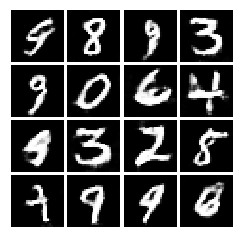


Iter: 1250, D: 1.371, G: 0.699, Q: 0.2858
Iter: 1300, D: 1.374, G: 0.6909, Q: 0.2817
Iter: 1350, D: 1.432, G: 0.7305, Q: 0.3105
Iter: 1400, D: 1.399, G: 0.7486, Q: 0.3974
Iter: 1450, D: 1.397, G: 0.7486, Q: 0.36


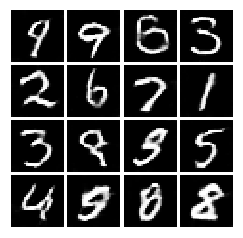


Iter: 1500, D: 1.36, G: 0.7255, Q: 0.4598
Iter: 1550, D: 1.43, G: 0.6885, Q: 0.3443
Iter: 1600, D: 1.389, G: 0.7024, Q: 0.2036
Iter: 1650, D: 1.346, G: 0.7357, Q: 0.3085
Iter: 1700, D: 1.353, G: 0.7614, Q: 0.4248


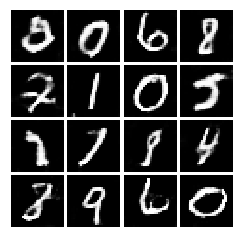


Iter: 1750, D: 1.437, G: 0.708, Q: 0.2809
Iter: 1800, D: 1.374, G: 0.7399, Q: 0.1823
Iter: 1850, D: 1.373, G: 0.7043, Q: 0.1821
Iter: 1900, D: 1.347, G: 0.7691, Q: 0.3386
Iter: 1950, D: 1.379, G: 0.7317, Q: 0.1832


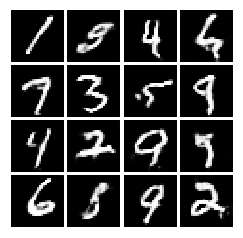


Iter: 2000, D: 1.405, G: 0.6801, Q: 0.3761
Iter: 2050, D: 1.379, G: 0.748, Q: 0.1927
Iter: 2100, D: 1.419, G: 0.7149, Q: 0.4219
Iter: 2150, D: 1.409, G: 0.6944, Q: 0.3042
Iter: 2200, D: 1.36, G: 0.7514, Q: 0.2489


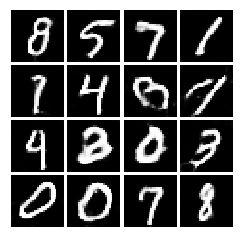


Iter: 2250, D: 1.392, G: 0.7396, Q: 0.2902
Iter: 2300, D: 1.49, G: 0.7389, Q: 0.1795
Iter: 2350, D: 1.408, G: 0.6909, Q: 0.217
Iter: 2400, D: 1.396, G: 0.7128, Q: 0.2304
Iter: 2450, D: 1.35, G: 0.7281, Q: 0.3018


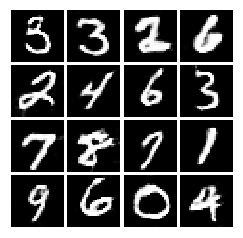


Iter: 2500, D: 1.37, G: 0.7075, Q: 0.1936
Iter: 2550, D: 1.368, G: 0.736, Q: 0.1557
Iter: 2600, D: 1.389, G: 0.734, Q: 0.3429
Iter: 2650, D: 1.381, G: 0.7266, Q: 0.2775
Iter: 2700, D: 1.451, G: 0.7337, Q: 0.3583


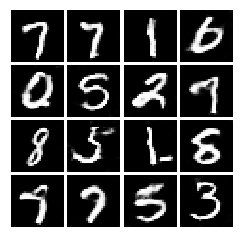


Iter: 2750, D: 1.376, G: 0.7504, Q: 0.1964
Iter: 2800, D: 1.389, G: 0.7318, Q: 0.1326
Iter: 2850, D: 1.334, G: 0.7547, Q: 0.3322
Iter: 2900, D: 1.403, G: 0.6918, Q: 0.254
Iter: 2950, D: 1.364, G: 0.7313, Q: 0.1138


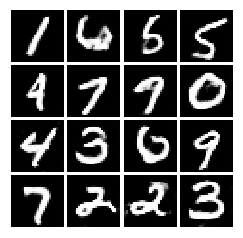


Iter: 3000, D: 1.395, G: 0.7388, Q: 0.1762
Iter: 3050, D: 1.358, G: 0.731, Q: 0.2269
Iter: 3100, D: 1.387, G: 0.706, Q: 0.2559
Iter: 3150, D: 1.37, G: 0.6879, Q: 0.2429
Iter: 3200, D: 1.349, G: 0.7502, Q: 0.2351


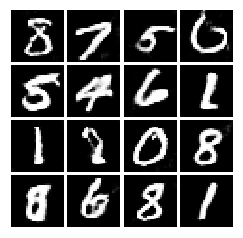


Iter: 3250, D: 1.361, G: 0.7166, Q: 0.1055
Iter: 3300, D: 1.378, G: 0.7151, Q: 0.1823
Iter: 3350, D: 1.391, G: 0.7164, Q: 0.1194
Iter: 3400, D: 1.364, G: 0.7335, Q: 0.2608
Iter: 3450, D: 1.35, G: 0.7301, Q: 0.3094


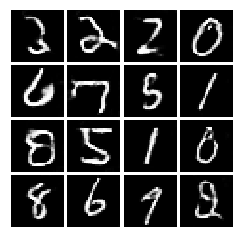


Iter: 3500, D: 1.369, G: 0.679, Q: 0.2952
Iter: 3550, D: 1.369, G: 0.7267, Q: 0.2401
Iter: 3600, D: 1.374, G: 0.7458, Q: 0.2026
Iter: 3650, D: 1.375, G: 0.7187, Q: 0.2591
Iter: 3700, D: 1.356, G: 0.7263, Q: 0.2062


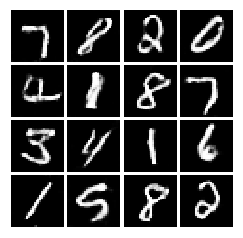


Iter: 3750, D: 1.394, G: 0.7088, Q: 0.2145
Iter: 3800, D: 1.382, G: 0.7245, Q: 0.1457
Iter: 3850, D: 1.402, G: 0.732, Q: 0.1842
Iter: 3900, D: 1.369, G: 0.7202, Q: 0.2232
Iter: 3950, D: 1.35, G: 0.7396, Q: 0.1109


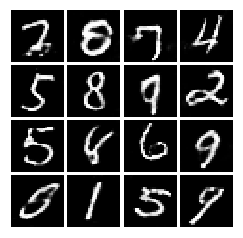


Iter: 4000, D: 1.417, G: 0.7112, Q: 0.2205
Iter: 4050, D: 1.407, G: 0.7265, Q: 0.114
Iter: 4100, D: 1.383, G: 0.7354, Q: 0.3845
Iter: 4150, D: 1.376, G: 0.7415, Q: 0.1038
Iter: 4200, D: 1.366, G: 0.7227, Q: 0.1754


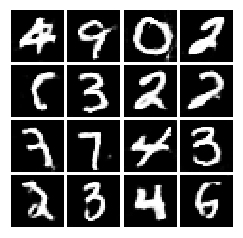


Iter: 4250, D: 1.386, G: 0.6974, Q: 0.2295
Final images


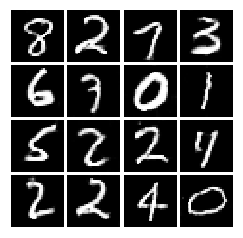

In [7]:
sess = get_session()
sess.run(tf.global_variables_initializer())
run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,Q_train_step,Q_loss,Q_extra_step,num_epoch=10)

## Results
Plotting images with varying categorical variable (1 to 10)

<Figure size 432x288 with 0 Axes>

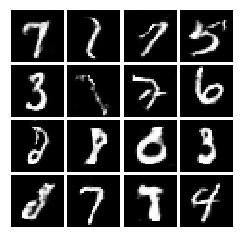

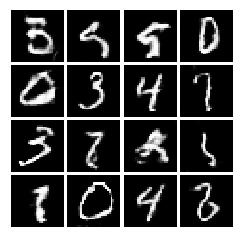

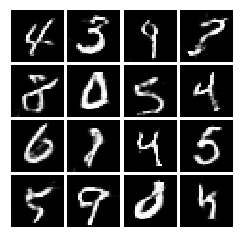

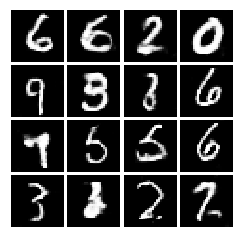

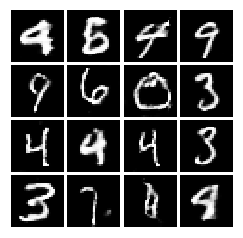

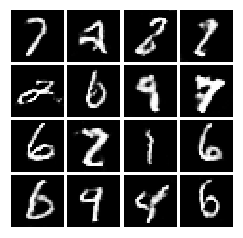

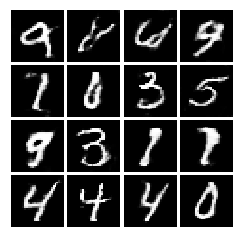

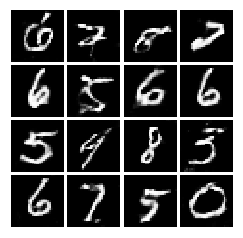

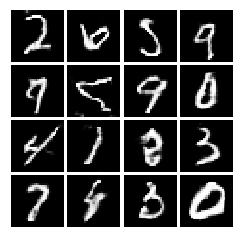

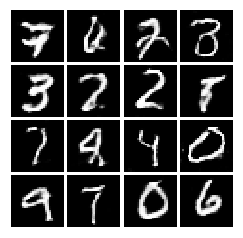

In [8]:
n_sample = 128
for i in range(10):
    cat_ = np.zeros(shape=[n_sample, 10])
    cat_[:, i] = 1
    samples = sess.run(G_sample, feed_dict={cat: cat_})
    plt.figure(i)
    fig = show_images(samples[:16])
plt.show()